In [1]:
import sys
try:
  import google.colab
  !{sys.executable} -m pip -q -q install pandas>=0.24.2
  !{sys.executable} -m pip -q -q install matplotlib>=3.0.3
  !{sys.executable} -m pip -q -q install seaborn>=0.9.1
  !{sys.executable} -m pip -q -q install numpy>=1.18.5
  !{sys.executable} -m pip -q -q install scikit-learn>=0.22.2
  !{sys.executable} -m pip -q -q install pycm>=2.2  
except:
  pass

In [6]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare

FOLD_NUMBER = 10
RANDOM_STATE = 23
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df = pd.read_csv('data.csv')

### Feature Selection

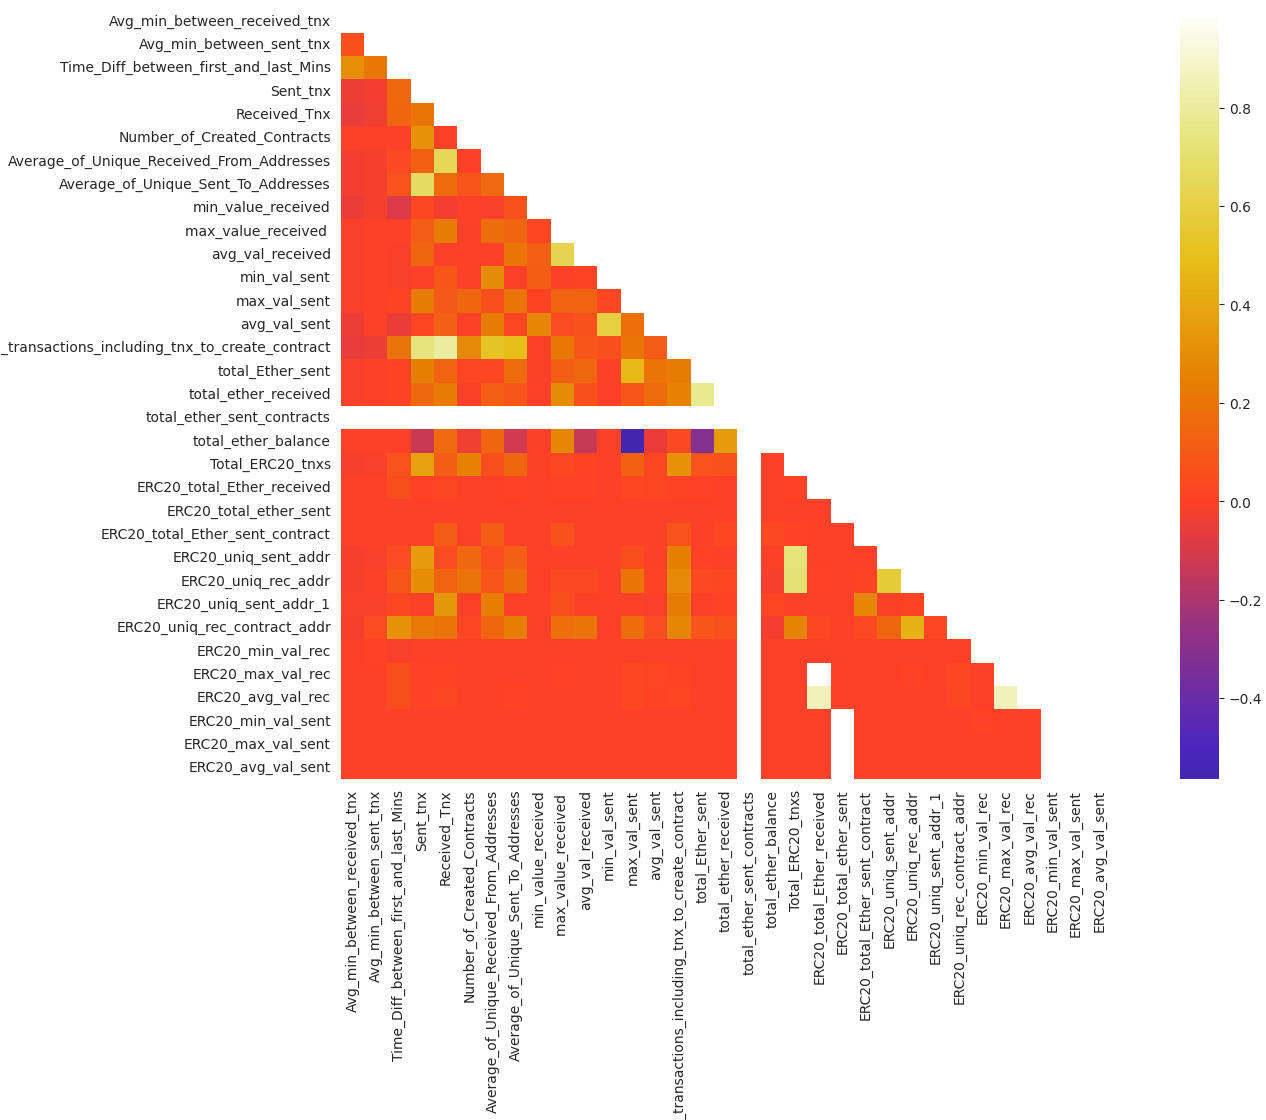

In [7]:
corr = df.iloc[:,2:-4].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

1. `total_ether_sent_contracts` is completly unused 

2. `ERC20_min_val_sent`, `ERC20_max_val_sent`, `ERC20_avg_val_sent` and `ERC20_total_ether_sent` have high correlation so we can remove 3 of them

3. `ERC20_max_val_rec` and `ERC20_total_Ether_reveived` have a high correlation so we can remove one of them

In [8]:
df.drop(["total_ether_sent_contracts", "ERC20_min_val_sent", "ERC20_max_val_sent", "ERC20_avg_val_sent", "ERC20_max_val_rec"], axis=1, inplace=True)

This dataset is imbalanced so we sample negative cases randomly to create a new balanced dataset.

In [9]:
positive_sample = df[df["FLAG"] == 1]
negative_sample = df[df["FLAG"] == 0].sample(len(positive_sample), random_state = RANDOM_STATE)
data = pd.concat([negative_sample, positive_sample], axis = 0)
y = data["FLAG"]
X = data.iloc[:,2:-4]

We replace `NaN` with average.

In [10]:
for col in X.columns:
    X[col] = X[col].fillna(X[col].mean())

### Preprocessing

We will use `StandardScaler` to standardize features by removing the **mean** and scaling to **unit variance**.

$$z=\frac{x-\mu}{\sigma}$$

### KNN

In statistics, the **k-nearest neighbors algorithm (k-NN)** is a non-parametric supervised learning method first developed by **Evelyn Fix** and **Joseph Hodges** in **1951**, and later expanded by **Thomas Cover**. 
In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

#### Parameters

In [11]:
knn_params = {"n_neighbors": 15}

#### Train

We will use **10-Folds** cross-validator. Split dataset into **10** consecutive folds.

Each fold is then used once as a validation while the **9** remaining folds form the training set.

In [12]:
knn_model = KNeighborsClassifier(**knn_params)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
knn_cm_worst = None
knn_cm_best = None
knn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    knn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = knn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    knn_cm_list.append(cm)
    if knn_cm_worst is None:
        knn_cm_worst = cm
    else:
        if cm.Overall_ACC < knn_cm_worst.Overall_ACC:
            knn_cm_worst = cm

    if knn_cm_best is None:
        knn_cm_best = cm
    else:
        if cm.Overall_ACC > knn_cm_best.Overall_ACC:
            knn_cm_best = cm

#### Performance

Model Name: KNN Classifier

10-Fold Metrics: 

Accuracy : 0.93

F1 : 0.93

Kappa : 0.86

Precision : 0.94

Recall : 0.92



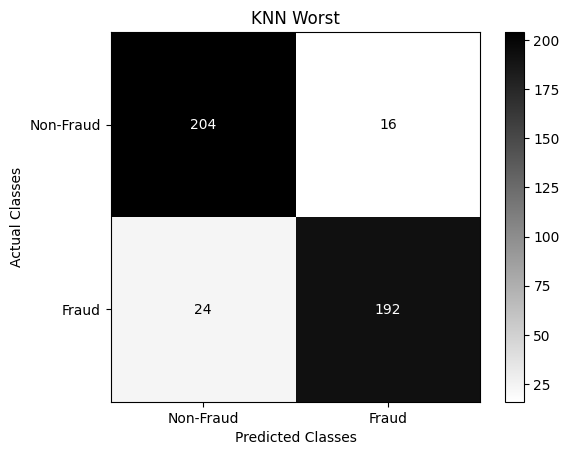

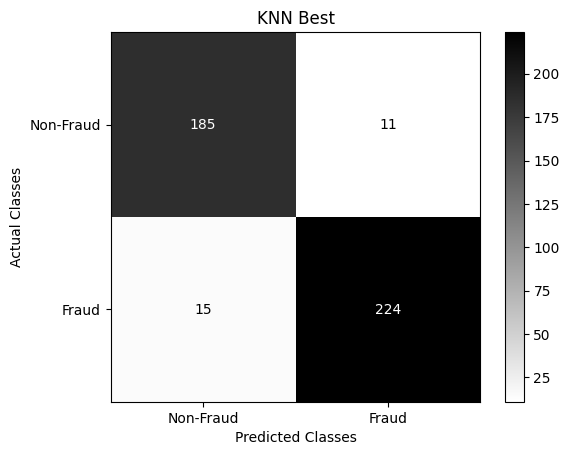

In [13]:
print("Model Name: KNN Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
knn_cm_worst.plot(title="KNN Worst", number_label=True)
knn_cm_best.plot(title="KNN Best", number_label=True)
plt.show()

### Random Forest

**Random forests** or **random decision forests** is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

#### Parameters

In [14]:
rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}

#### Train

We will use **10-Folds** cross-validator. Split dataset into **10** consecutive folds.

Each fold is then used once as a validation while the **9** remaining folds form the training set.

In [15]:
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
rf_cm_worst = None
rf_cm_best = None
rf_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    rf_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = rf_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    rf_cm_list.append(cm)
    if rf_cm_worst is None:
        rf_cm_worst = cm
    else:
        if cm.Overall_ACC < rf_cm_worst.Overall_ACC:
            rf_cm_worst = cm

    if rf_cm_best is None:
        rf_cm_best = cm
    else:
        if cm.Overall_ACC > rf_cm_best.Overall_ACC:
            rf_cm_best = cm

#### Performance

Model Name: Random Forest Classifier

10-Fold Metrics: 

Accuracy : 0.98

F1 : 0.98

Kappa : 0.95

Precision : 0.98

Recall : 0.97



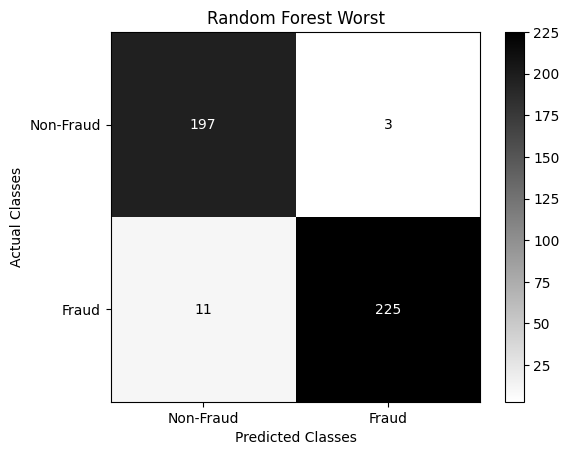

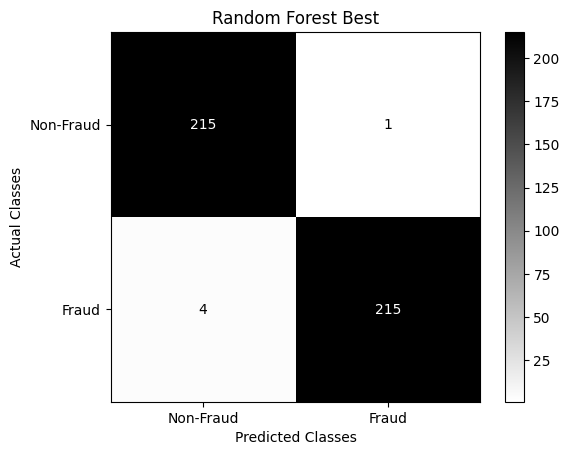

In [16]:
print("Model Name: Random Forest Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
rf_cm_worst.plot(title="Random Forest Worst", number_label=True)
rf_cm_best.plot(title="Random Forest Best", number_label=True)
plt.show()

#### Interpretation

**Random Forest** is an interpretable model and we can plot the trees and feature importances.

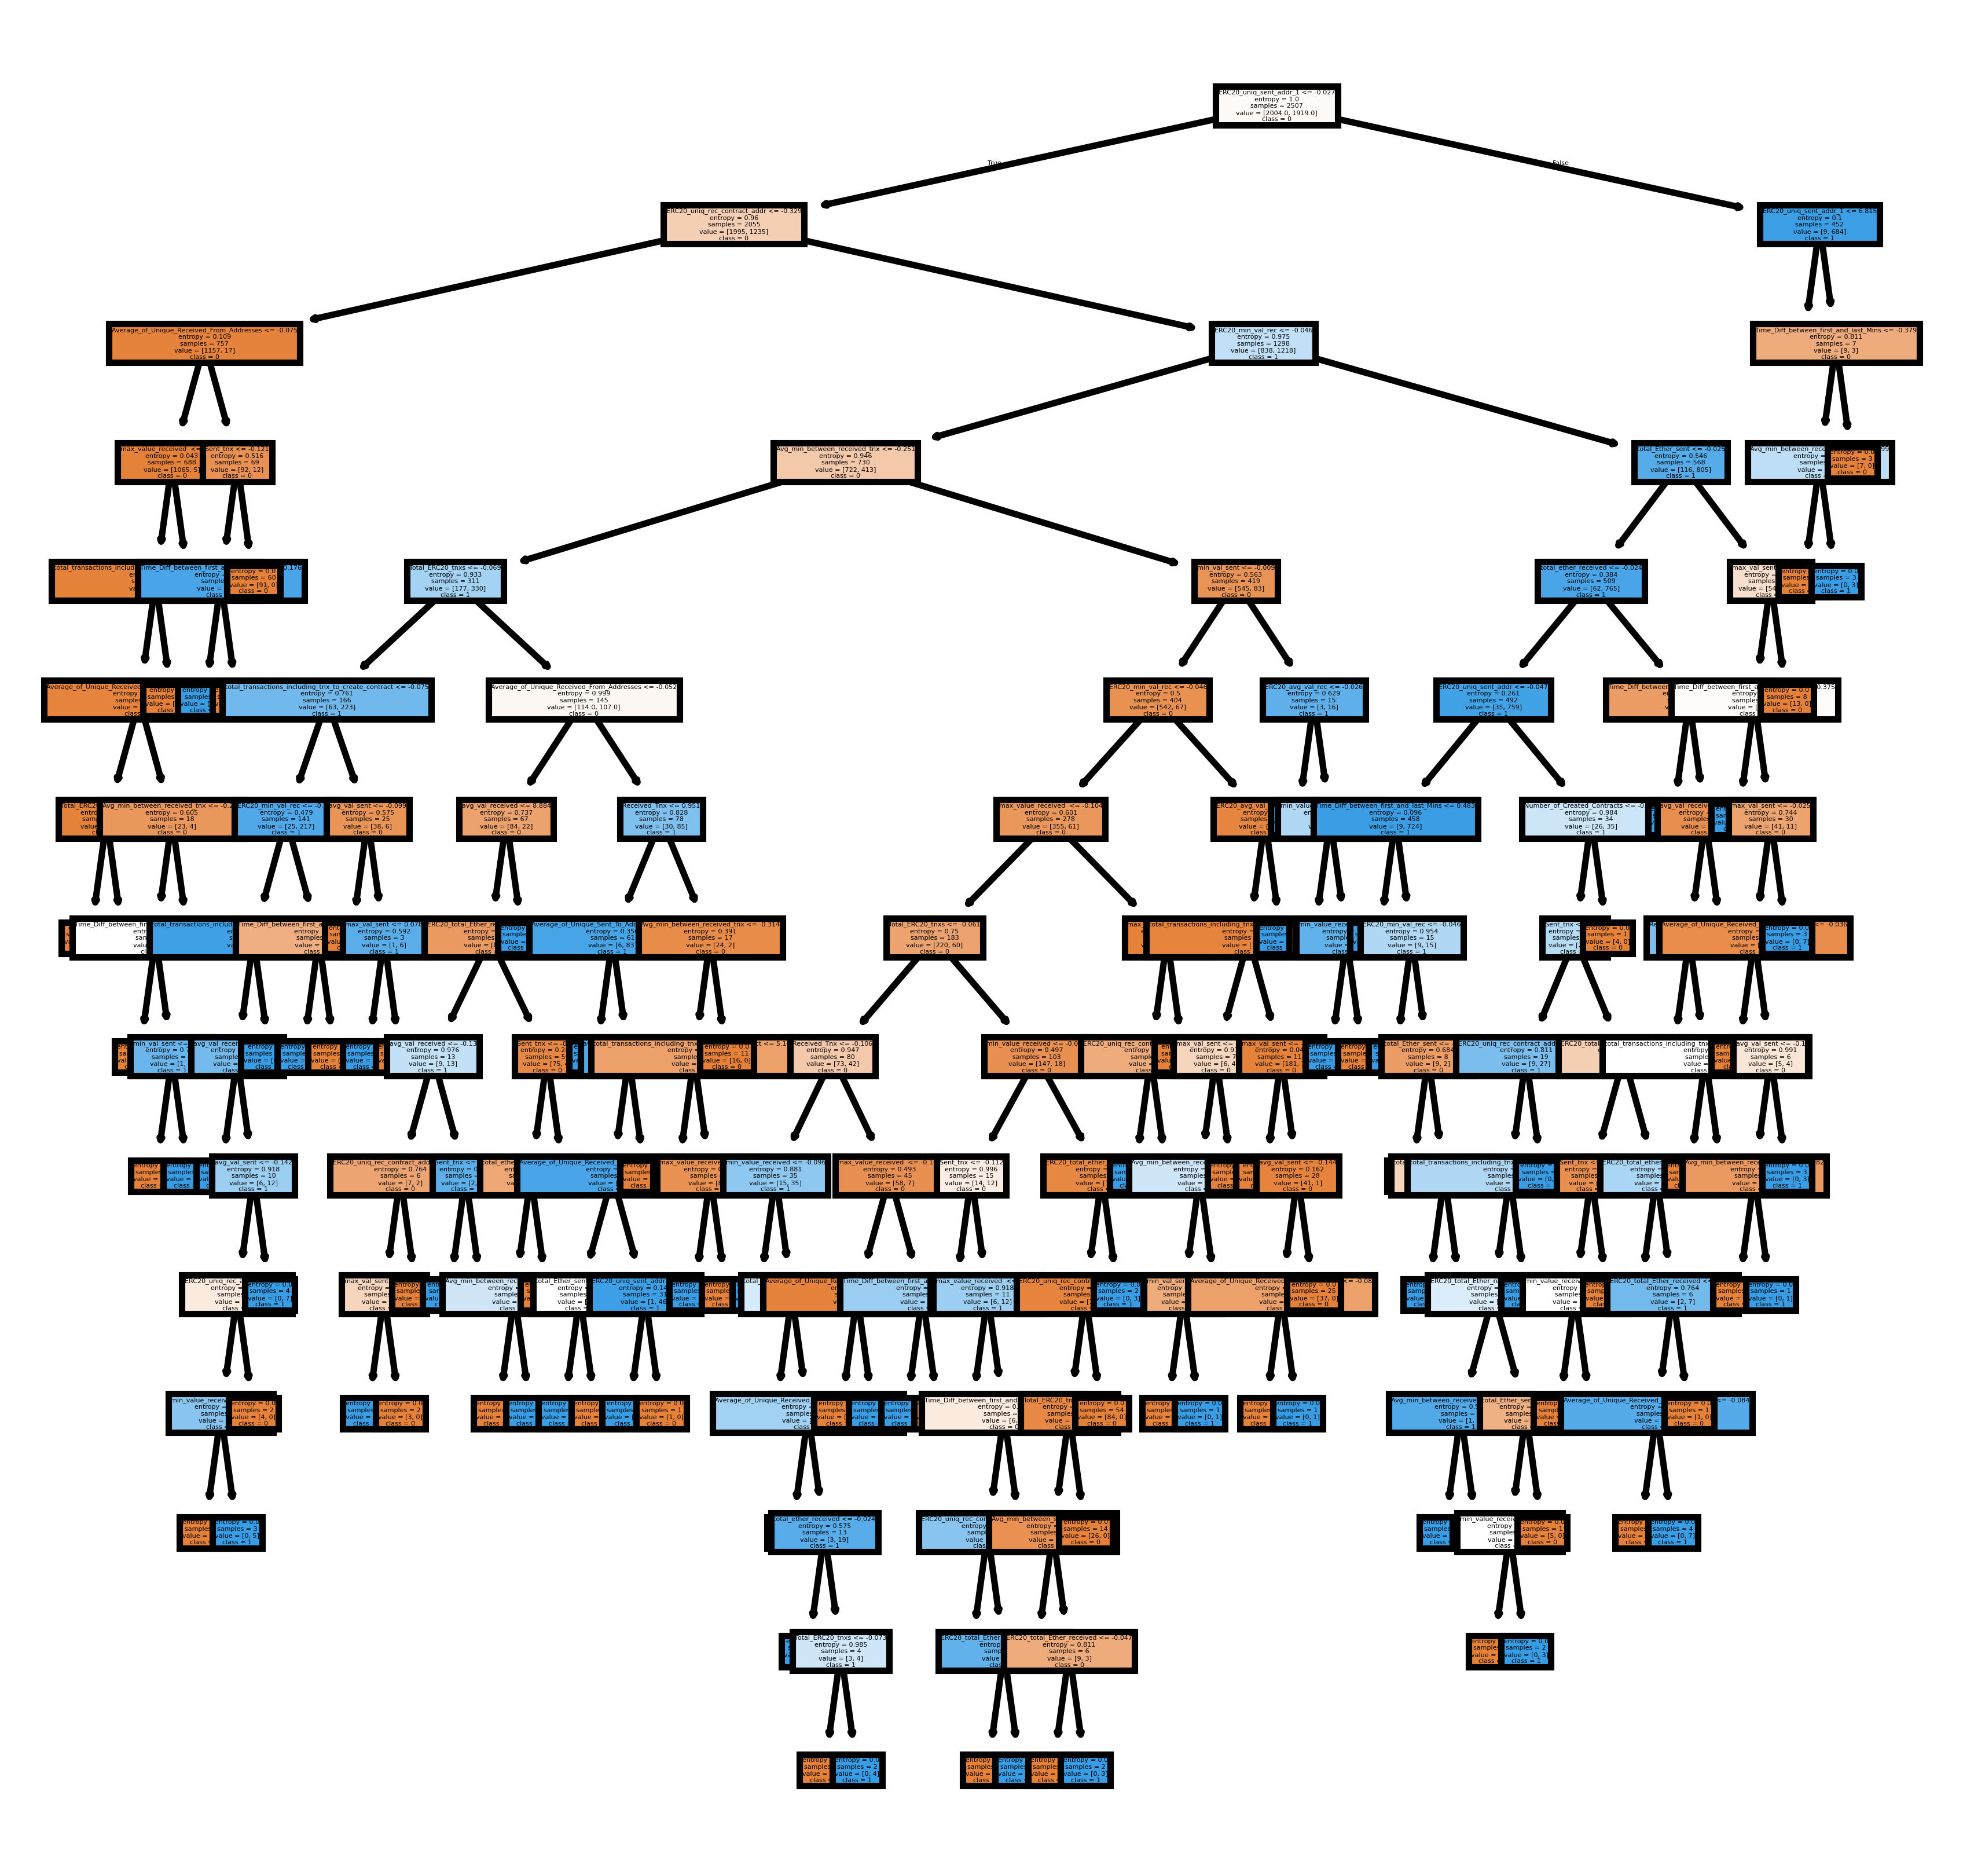

In [17]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
plot_tree(rf_model.estimators_[0],
               feature_names = X.columns, 
               class_names=["0","1"],
               filled = True);

In [18]:
len(rf_model.feature_importances_)

28

In [19]:
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

ERC20_min_val_rec                                      0.165008
Total_ERC20_tnxs                                       0.126774
Time_Diff_between_first_and_last_Mins                  0.097982
ERC20_uniq_rec_addr                                    0.081204
ERC20_uniq_rec_contract_addr                           0.061808
Avg_min_between_received_tnx                           0.044710
Average_of_Unique_Received_From_Addresses              0.042508
avg_val_received                                       0.033827
total_transactions_including_tnx_to_create_contract    0.032892
total_ether_received                                   0.032471
ERC20_total_Ether_sent_contract                        0.029959
Received_Tnx                                           0.022805
min_val_sent                                           0.021011
ERC20_avg_val_rec                                      0.020316
max_value_received                                     0.020114
Sent_tnx                                

⚠️ We can see that `Total_ERC20_tnxs`, `ERC20_min_val_rec`, `Time_Diff_between_first_and_last_Mins` have a huge impact on final decision.

### Neural Network

A **multilayer perceptron (MLP)** is a fully connected class of feedforward artificial neural network (ANN).
An MLP consists of at least three layers of nodes: an **input layer**, a **hidden layer** and an **output layer**. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

#### Parameters

In [20]:
nn_params = {"hidden_layer_sizes": (100, 100), "solver": "adam"}

#### Train

We will use **10-Folds** cross-validator. Split dataset into **10** consecutive folds.

Each fold is then used once as a validation while the **9** remaining folds form the training set.

In [21]:
nn_model = MLPClassifier(**nn_params)
nn_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
nn_cm_worst = None
nn_cm_best = None
nn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    nn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = nn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    nn_cm_list.append(cm)
    if nn_cm_worst is None:
        nn_cm_worst = cm
    else:
        if cm.Overall_ACC < nn_cm_worst.Overall_ACC:
            nn_cm_worst = cm

    if nn_cm_best is None:
        nn_cm_best = cm
    else:
        if cm.Overall_ACC > nn_cm_best.Overall_ACC:
            nn_cm_best = cm

#### Performance

Model Name: Neural Network Classifier
10-Fold Metrics: 

Accuracy : 0.96

F1 : 0.96

Kappa : 0.93

Precision : 0.96

Recall : 0.96



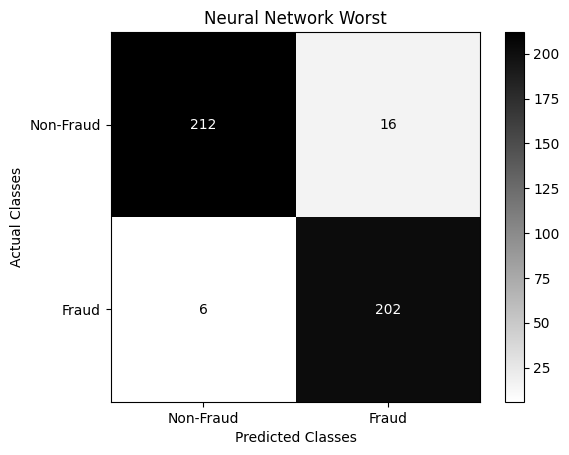

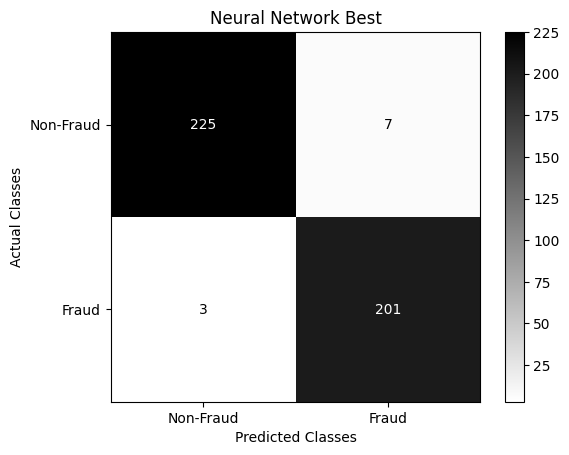

In [22]:
print("Model Name: Neural Network Classifier")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
nn_cm_worst.plot(title="Neural Network Worst", number_label=True)
nn_cm_best.plot(title="Neural Network Best", number_label=True)
plt.show()

### Models Compare

In [23]:
rf_combined_cm = None
nn_combined_cm = None
knn_combined_cm = None
for index, cm in enumerate(rf_cm_list):
    if rf_combined_cm is None:
        rf_combined_cm = cm
    else:
        rf_combined_cm = rf_combined_cm.combine(cm)
    
    if nn_combined_cm is None:
        nn_combined_cm = nn_cm_list[index]
    else:
        nn_combined_cm = nn_combined_cm.combine(nn_cm_list[index])
    
    if knn_combined_cm is None:
        knn_combined_cm = knn_cm_list[index]
    else:
        knn_combined_cm = knn_combined_cm.combine(knn_cm_list[index])

In [24]:
cp = Compare({"Random Forest":rf_combined_cm, "Neural Network":nn_combined_cm, "KNN":knn_combined_cm})

In [25]:
print(cp)

Best : None

Rank   Name              Class-Score       Overall-Score
1      Neural Network    0.91667           0.95238
1      Random Forest     0.91667           0.95238
3      KNN               0.88333           0.92381



In [30]:
import joblib

joblib.dump(nn_model, "nn_model.pkl")
print("Model is saved as nn_model.pkl")

Model is saved as nn_model.pkl


In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
scaler.fit(X)

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']